In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


from timeit import default_timer
from Solver import *
from functools import partial

import torch

import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import NeuralNet
import PlotDefault



In [2]:
beta_rek_strs = [("1", "0p3"), ("2", "0p3"), ("3", "0p3"), ("1", "0p6"), ("2", "0p6"), ("3", "0p6")]

beta_reks = [ (str_to_num(beta_rek_strs[i][0]), str_to_num(beta_rek_strs[i][1])) for i in range(len(beta_rek_strs)) ]
physics_params, q_mean, psi_mean, dpv_mean,  mu_mean, mu_mean_clip,  closure_mean, yy, force = load_data(beta_rek_strs = beta_rek_strs, beta_reks = beta_reks)

# Visualize data

Text(0.5, 0.98, 'bottom layer')

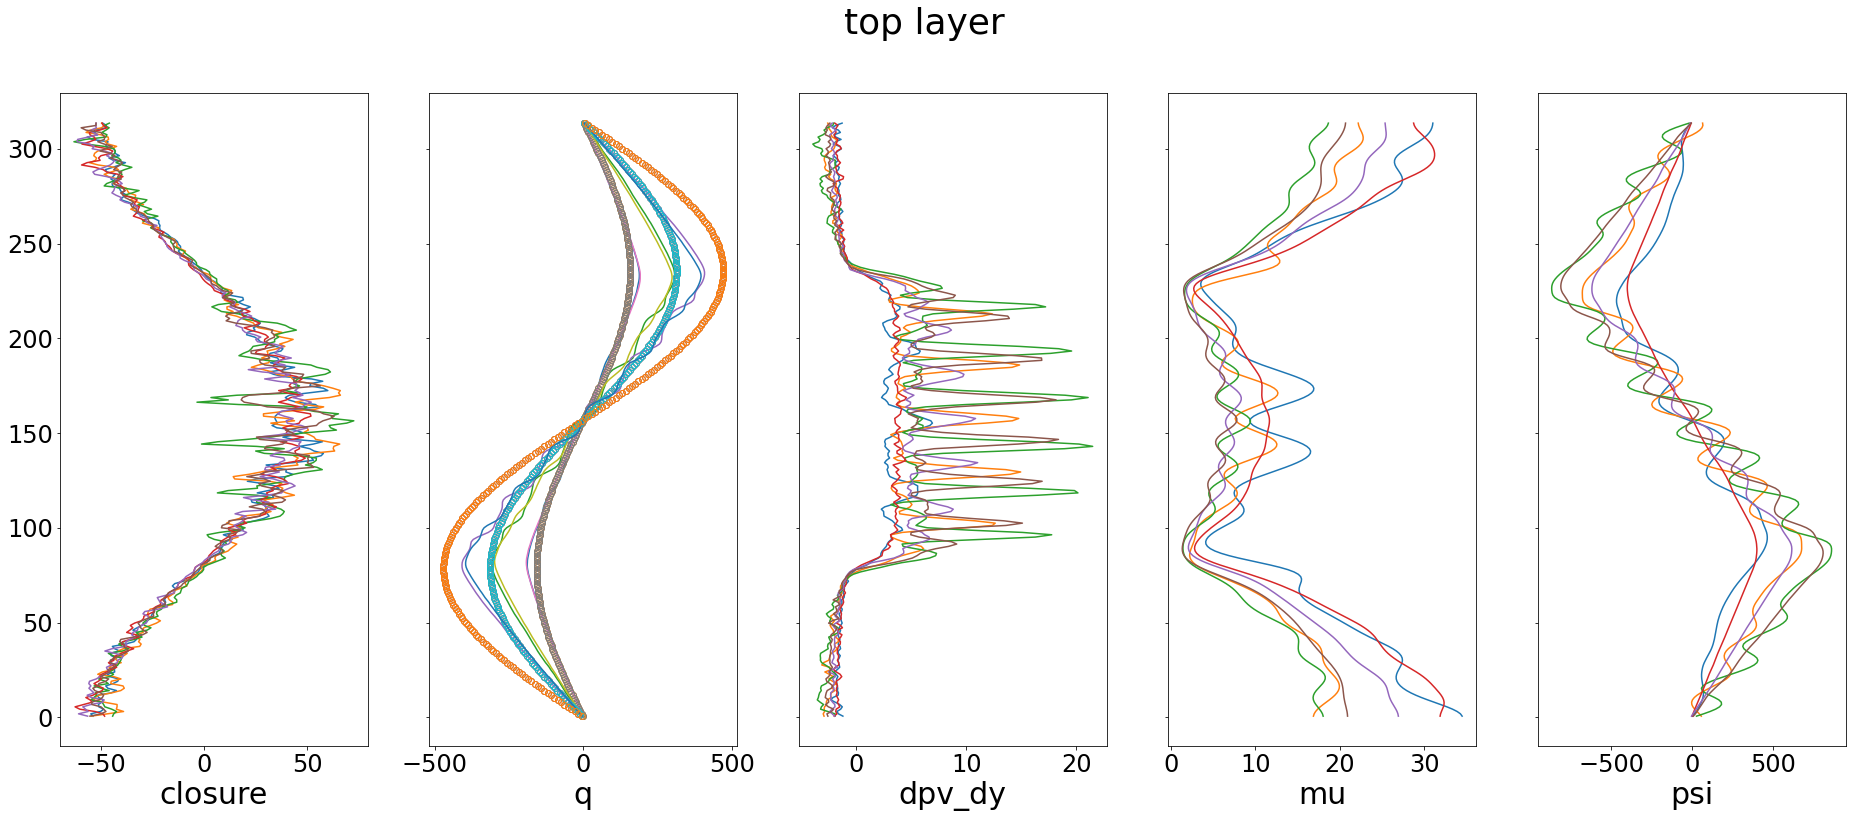

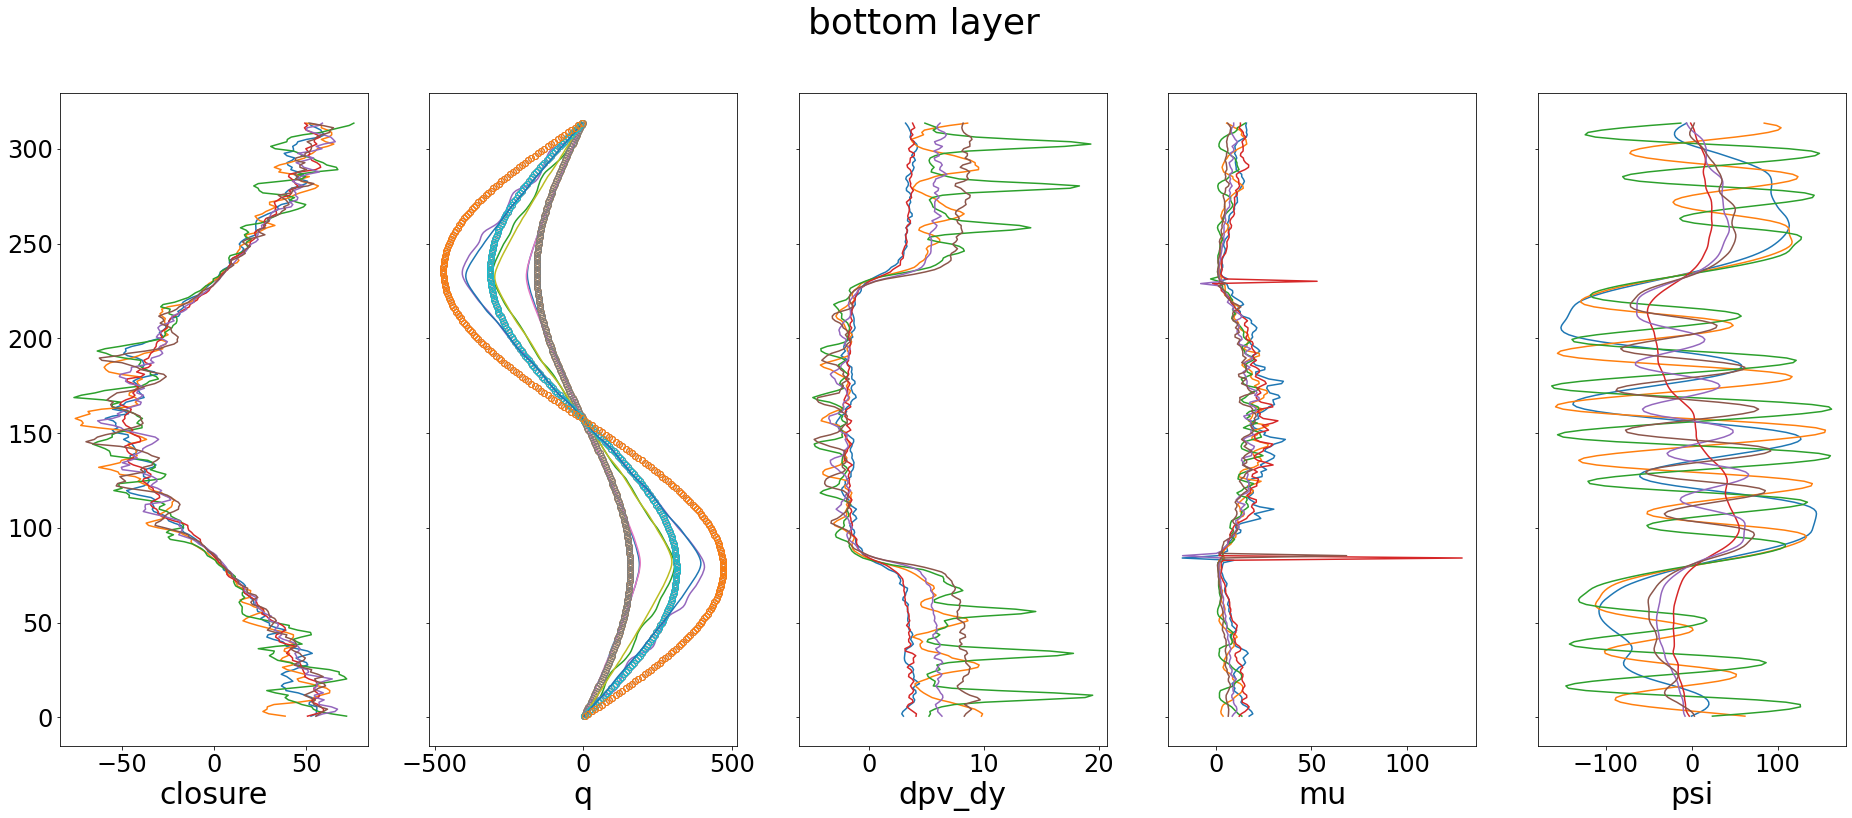

In [3]:
L = 50.0 *2*np.pi

N_data = len(beta_reks)
layer = 0
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
    
    ax[1].plot(-beta_reks[i][0]*L/2*np.sin(2*np.pi*yy/L), yy, "o", fillstyle="none")
    
    
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean_clip[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("top layer")

layer = 1
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
               
    ax[1].plot(beta_reks[i][0]*L/2*np.sin(2*np.pi*yy/L), yy, "o", fillstyle="none")
                          
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("bottom layer")

# scatter training points

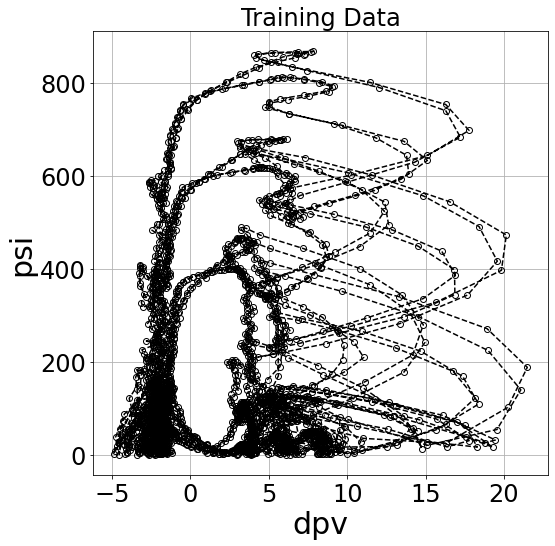

In [6]:
plt.figure(figsize=(8,8))
for i in range(N_data):
#     plt.plot(np.fabs(q_mean[i,0,:]), dpv_mean[i, 0, :],  "--o", color = "black", fillstyle="none")
#     plt.plot(np.fabs(q_mean[i,1,:]), dpv_mean[i, 1, :],  "--o", color = "black", fillstyle="none")
    plt.plot(dpv_mean[i, 0, :], np.fabs(psi_mean[i,0,:]),   "--o", color = "black", fillstyle="none")
    plt.plot(dpv_mean[i, 1, :], np.fabs(psi_mean[i,1,:]),  "--o", color = "black", fillstyle="none")
    
plt.grid("on")
plt.xlabel("dpv")
plt.ylabel("psi")
plt.title("Training Data")

    
plt.subplots_adjust(bottom=0.15,top=0.92,left=0.18,right=0.97)
plt.savefig("QG-Training-Data.pdf")

In [7]:
# scale input 
nn_save_name = "direct.nn"
# np.fabs(q_mean).flatten()/q_scale,
x_train = torch.from_numpy(np.stack(( dpv_mean.flatten()/dpv_scale, np.fabs(psi_mean).flatten()/psi_scale)).T.astype(np.float32)) 
y_train = torch.from_numpy(mu_mean.flatten()[:,np.newaxis].astype(np.float32)) / mu_scale



ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 10000
batch_size = 64


net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    net.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = net(x)
        
        loss = myloss(out , y)*100
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

#     scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
        if nn_save_name is not None:
            torch.save(net, nn_save_name)
        


/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  0  Epoch time :  0.15044685220345855  Train L2 Loss :  47939.61071777344
Epoch :  100  Epoch time :  0.06420331494882703  Train L2 Loss :  2128.7674312591553
Epoch :  200  Epoch time :  0.03956283209845424  Train L2 Loss :  2104.634835243225
Epoch :  300  Epoch time :  0.053155960980802774  Train L2 Loss :  2016.83944606781
Epoch :  400  Epoch time :  0.037391936872154474  Train L2 Loss :  2006.0029287338257
Epoch :  500  Epoch time :  0.05857567861676216  Train L2 Loss :  2002.7339420318604
Epoch :  600  Epoch time :  0.05890764016658068  Train L2 Loss :  1998.8720121383667
Epoch :  700  Epoch time :  0.05427948106080294  Train L2 Loss :  1996.8401651382446
Epoch :  800  Epoch time :  0.0488973599858582  Train L2 Loss :  1993.2366762161255
Epoch :  900  Epoch time :  0.051903021056205034  Train L2 Loss :  1991.1911315917969
Epoch :  1000  Epoch time :  0.04120791703462601  Train L2 Loss :  1989.860195159912
Epoch :  1100  Epoch time :  0.05960671603679657  Train L2 Loss :  19

KeyboardInterrupt: 